In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 9.8 MB/s 


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.7 MB/s 
     |████████████████████████████████| 163 kB 34.4 MB/s 


In [4]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [6]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256 # 1st value 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync # 1st value 8
EPOCHS = 6 # fist value 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

data read

In [8]:
df = pd.read_json("DF_Recommendation_11_14_2022.json")
df.head()

,Section,Concept,Type,Corpus,Synonyms,Keywords,Entities,Ref,Definition,Concept_range,Relation_Non_Taxonomique,topic
0,1.0.0.0,Project scope management,,Project Scope Management includes the process ...,[scope management plan Document project produc...,"[[scope, 0.48860000000000003], [management, 0....","[[[Project, Scope, Management]], [[process]], ...","[[[[['Figure 5-1'], []], []], []], []]",Project Scope Management includes the process ...,"[Project Scope Management, defining, Collect R...","[includes, required ensure, includes, required...",Project scope management
1,1.1.0.0,Plan scope management,,Plan Scope Management is the process of creati...,"[planning, procedures, documentation, manageme...","[[scope, 0.48], [management, 0.313200000000000...","[[[Plan, Scope, Management]], [[process]], [[s...","[[[[['Figure 5-3', 'Figure 5-2'], []], ['Secti...",Plan Scope Management is the process of creati...,"[Plan Scope Management, process, scope managem...","[is, creating, will be defined controlled, is ...",Project scope management
2,1.1.1.1,Project charter,Has_Inputs,Described in Section The project charter Docum...,"[project, requirements, description, charter, ...","[[requirements, 0.5116], [constraints, 0.37260...","[[[Section]], [[project, charter, Document]], ...","[[[[[], []], ['Section 4.1.3.1']], ['Section 4...",The project charter Document the project purpo...,[],[],Project scope management
3,1.1.1.2,Project management plan,Has_Inputs,Described in Section Project management plan c...,[organization quality policy methodologies sta...,"[[agile, 0.4672], [development, 0.409000000000...","[[[Section, Project, management, plan, commons...","[[[[[], []], ['Section 8.1.3.1', 'Section 4.2....",Project management plan commons include but ar...,"[Project management plan commons, organization...","[include are limited, will be managed can be i...",Project scope management
4,1.1.1.3,Enterprise environmental factors,Has_Inputs,The enterprise environmental factors that can ...,"[factors, requirements, environmental, enterpr...","[[scope, 0.4032], [enterprise, 0.3999000000000...","[[[enterprise]], [[factors]], [[Plan, Scope, M...","[[[[[], []], []], []], []]",The enterprise environmental factors that can ...,[enterprise factors],"[can influence, are limited]",Project scope management


In [9]:
df.drop(columns=['Section','Keywords','Entities','Ref','Synonyms','Concept_range','Relation_Non_Taxonomique','Corpus','topic','Type'],inplace= True)

In [10]:
df

,Concept,Definition
0,Project scope management,Project Scope Management includes the process ...
1,Plan scope management,Plan Scope Management is the process of creati...
2,Project charter,The project charter Document the project purpo...
3,Project management plan,Project management plan commons include but ar...
4,Enterprise environmental factors,The enterprise environmental factors that can ...
...,...,...
211,Work performance information,Work performance information includes informat...
212,Cost forecasts,Either a calculated A value or a bottom up A v...
213,Change requests,Analysis of project performance may result in ...
214,Project management plan updates,Any change to the project management plan goes...


In [11]:
df.iloc[54][1]

'Verified deliverables are project deliverables that are completed and checked for correctness through the Control Quality process '

In [12]:
X_data = df[['Definition']].to_numpy().reshape(-1)
y_data = df[['Concept']].to_numpy().reshape(-1)

tokenization

In [13]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [14]:
# Transform categories into numbers
Concept_to_id = {}
Concept_to_name = {}

for index, c in enumerate(y_data):
    if c in Concept_to_id:
        Concept_id = Concept_to_id[c]
    else:
        Concept_id = len(Concept_to_id)
        Concept_to_id[c] = Concept_id
        Concept_to_name[Concept_id] = c
    
    y_data[index] = Concept_id

# Display dictionary
Concept_to_name

{0: 'Project scope management',
 1: 'Plan scope management',
 2: 'Project charter',
 3: 'Project management plan',
 4: 'Enterprise environmental factors',
 5: 'Organizational process assets',
 6: 'Expert judgment',
 7: 'Data analysis',
 8: 'Meetings',
 9: 'Scope management plan',
 10: 'Requirements management plan',
 11: 'Collect requirements',
 12: 'Project documents',
 13: 'Business documents',
 14: 'Agreements',
 15: 'Data gathering',
 16: 'Decision making',
 17: 'Data representation',
 18: 'Interpersonal and team skills',
 19: 'Context diagram',
 20: 'Prototypes',
 21: 'Requirements documentation',
 22: 'Requirements traceability matrix',
 23: 'Define scope',
 24: 'Product analysis',
 25: 'Project scope statement',
 26: 'Project documents updates',
 27: 'Create wbs',
 28: 'Decomposition',
 29: 'Scope baseline',
 30: 'Validate scope',
 31: 'Verified deliverables',
 32: 'Work performance data',
 33: 'Inspection',
 34: 'Accepted deliverables',
 35: 'Work performance information',
 36:

split train test

In [15]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=777)

In [16]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

encoding

In [17]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [18]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(344, activation='tanh')(x)
        x = tf.keras.layers.Dense(172, activation='tanh')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [19]:

Concepts = df['Concept'].unique()
n_concepts = len(Concepts)

with strategy.scope():
    model = build_model(n_concepts)
    model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

train model

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/6


22/22 [==============================] - 623s 27s/step - loss: 4.2234 - accuracy: 0.1570 - val_loss: 3.6875 - val_accuracy: 0.2727
Epoch 2/6
22/22 [==============================] - 574s 26s/step - loss: 2.4273 - accuracy: 0.5233 - val_loss: 2.7917 - val_accuracy: 0.4318
Epoch 3/6
22/22 [==============================] - 581s 27s/step - loss: 0.9883 - accuracy: 0.9012 - val_loss: 2.4685 - val_accuracy: 0.5909
Epoch 4/6
22/22 [==============================] - 527s 24s/step - loss: 0.3617 - accuracy: 0.9942 - val_loss: 2.2992 - val_accuracy: 0.5909
Epoch 5/6
22/22 [==============================] - 522s 24s/step - loss: 0.1485 - accuracy: 0.9884 - val_loss: 2.2678 - val_accuracy: 0.5909
Epoch 6/6
22/22 [==============================] - 517s 23s/step - loss: 0.0956 - accuracy: 0.9942 - val_loss: 2.2420 - val_accuracy: 0.5909


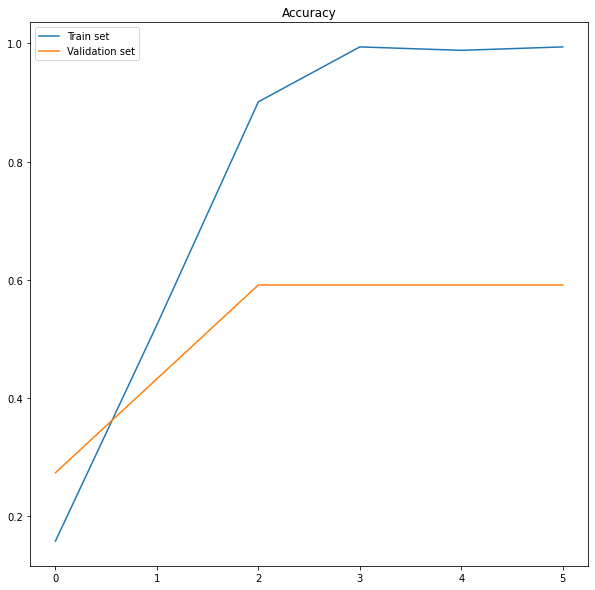

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

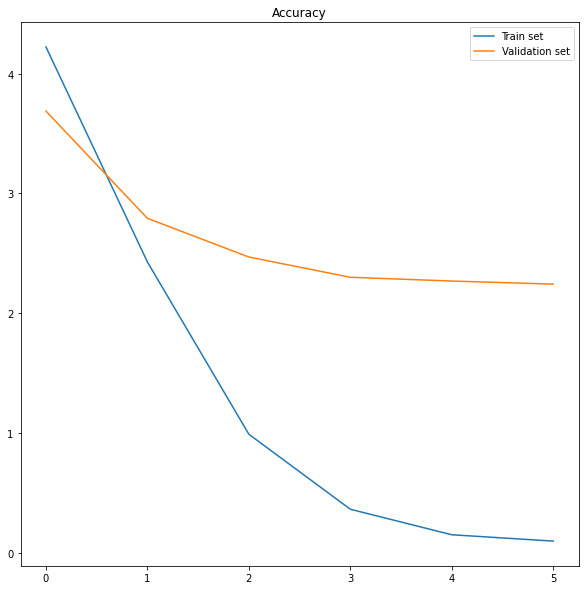

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['loss']))
plt.plot(xaxis, history.history['loss'], label='Train set')
plt.plot(xaxis, history.history['val_loss'], label='Validation set')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 59.09%


2/2 [==============================] - 37s 10s/step


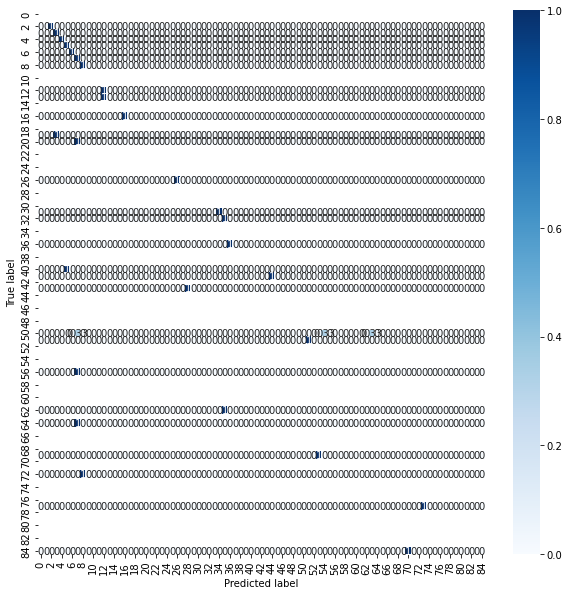

In [ ]:
plot_confusion_matrix(X_test, y_test, model)

Exporting model

In [ ]:
model.save("saved_model/my_model")

In [ ]:
model.save("saved_model/my_model.h5")

In [ ]:
!zip -r /content/model.zip /content/saved_model/my_model

  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 93%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 95%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 80%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


loading model


In [ ]:
new_model = tf.keras.models.load_model('/variables/')

OSError: ignored

In [ ]:
xxxx = roberta_encode(["Project management plan"], tokenizer)

In [ ]:
 yy= model.predict(xxxx)

In [ ]:
yy

In [ ]:
np.argmax(yy)

In [ ]:
Concept_to_name